In [6]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

In [7]:

#----------------
#Input parameters
#----------------
#These parmeters are used for different shapes of input

# ------------------------
# Double exponential curve
# ------------------------

#Initiate these variables
A = 0
d_rise = 0
r_rise = 0
d_decay = 0
r_decay = 0
t_star = 0 #when to start the IP3 transient



#--------------------------------------------
#Step input pulse input and oscillation input
#--------------------------------------------
step_max_value = 1 #maximum value during the ip3 step input
step_time_scale = 1


#Square wave glutamate pulse parameters
input_start = 10
input_duration = 50
input_max = 0.3
input_min = 0

#Oscillation parameters
num_oscillations = 10
oscillation_on_duration = 50
oscillation_off_duration = 150



'''
--------------------------
Input functions
--------------------------
These functions are used to give manual input for glutamate or IP3
The exact shape of input can be modified by changing global parameters
One of the following input string types should be passed in the 
    run_experiment functions

E.g., input_duration = 500
    will make a 'pulse' type input last for 500 seconds

Input types:
    'pulse': used for constant input value, params are
        input_start:        when the input starts
        input_duration:     how long input lasts
        input_max:          how large the input is when on
        input_min:          how large the input is when off
    'step': used for input that will step up every 150s uniformly to a max 
        step_max_value:     the max value the step will reach
        e.g. if it is 1, the steps will be [0, 0.25, 0.5, 0.75, 0.1, 0.75, 0.5, 0.25, 0]
        step_time_scale:    how long each step will last
        e.g. if it is 1, each step lasts 150s, if it is 2, each step lasts 300s
    'oscillation': input will oscillate between on and off
        input_min, input_max: min/max values of oscillation
        num_oscilations:      how many oscillations
        oscillation_on_duration, oscillation_off_duration: how long each on/off 
                                                           phase will last
    'exponential_oscillation': same as 'oscillation' but will rise and fall
        exponentially
    'curve': this is a double exponential curve
        A, d_rise, d_decay, r_rise, r_decay
'''

def get_input_value(input_type, t):
    '''
    Helper function - given a certain input type and time t
    return the value for the input
    '''
    if(input_type == 'pulse'):
        return pulse_input(t)
    elif(input_type == 'step'):
        return step_input(t)
    elif(input_type == 'oscillation'):
        return oscillation_input(t)
    elif(input_type == 'curve'):
        return curve_input(t)
    elif(input_type == 'exponential_oscillation'):
        return exponential_oscillation(t)

    else:
        return 0




def get_input_plot(input_type):
    '''
    This function simply returns t and y values to plot
    based on the type of input curve that we used
    E.g., we could call this to get glut_t, glut for the glutamate
    input plot
    '''
    t = np.arange(t_0, t_f, 0.1)
    y = []
    for x in t:
        y.append(get_input_value(input_type, x))
    y = np.array(y)
    return t, y





def pulse_input(t):
    '''
    This function tells us what value glutamate takes at a given time t
    Currently set to square wave
    '''
    if(t > input_start and t < (input_start + input_duration)):
        glut = input_max
    else:
        glut = input_min
    return glut





def oscillation_input(t):
    '''
    This function creates an oscillatory glutamate input
    '''
    principle_t = (t) % (oscillation_on_duration + oscillation_off_duration)
    
#     print((oscillation_off_duration + oscillation_on_duration) * num_oscillations)
    if(principle_t < oscillation_on_duration and
        t < (oscillation_off_duration + oscillation_on_duration) * num_oscillations):
        return input_max
    else:
        return input_min
    
    
    

def exponential_oscillation(t):
    '''
    This function creates an oscillatory glutamate input where the input grows
    and falls exponentially
    '''
    #compute our IP3 curve helper functions
    oscillation_on_duration = d_rise + d_decay
    principle_t = t % (oscillation_on_duration + oscillation_off_duration)
    
    if(principle_t < oscillation_on_duration and
      t < (oscillation_on_duration + oscillation_off_duration) * num_oscillations):
        s_inf = A / (1 - np.exp(-r_rise * d_rise))
        if(principle_t < d_rise):
            return s_inf * (1 - np.exp(-r_rise * (principle_t)))
        elif(principle_t >= d_rise):
            return A * np.exp(-r_decay * (principle_t - d_rise))
    else:
        return 0





def exponential_input(t):
    '''
    This function will generate an exponential increase and decay glutamate input
    '''
    input_half = input_duration / 2
    if(t > input_start and t <= (input_start + input_half)):
        return input_max * (1 - np.exp((t - input_start) / (t - input_start - input_half)))
    elif(t > (input_start + input_half) and t <= (input_start + input_duration)):
        return input_max * np.exp((t - input_start - input_half) / (t - input_start - input_duration))
    else:
        return input_min





def curve_input(t):
    '''
    This function tell us what value IP3 takes at a given time t
    if we want to expicitly use IP3 as an input to compute
    the calcium dynamics for a given IP3 transient
    To set the parameters for this curve, use set_ip3_curve()
    '''
    #compute our IP3 curve helper functions
    if(A != 0):
        s_inf = A / (1 - np.exp(-r_rise * d_rise))
        if(t < t_star):
            return 0
        elif(t >= t_star and t < (t_star + d_rise)):
            return s_inf * (1 - np.exp(-r_rise * (t - t_star)))
        elif(t >= (t_star + d_rise)):
            return A * np.exp(-r_decay * (t - t_star - d_rise))
    else:
        #return steady state IP3
        return 0.056767761
    
    



def step_input(t):
    '''
    This function will create an IP3 input that increases stepwise
    0-50s: 0
    50-200s: 0.125
    200-350s: 0.250
    350-500s: 0.375
    500-650s: 0.5
    650-800s: 0.375
    800-950s: 0.250
    950-1100s: 0.125
    1100s-: 0
    '''
    #times at which the concentration changes
    time_breaks = np.array([0, 50, 200, 350, 500, 650, 800, 950, 1100]) * step_time_scale
    #values the concentration changes to at each interval
    input_values = np.array([0, 0.25, 0.5, 0.75, 1, 0.75, 0.5, 0.25, 0]) * step_max_value

    for i in range(len(time_breaks)):
        #check if t is after last time_break
        if(i == len(time_breaks) - 1):
            if(t >= time_breaks[i]):
                return input_values[i]

        #check which interval t is in
        else:
            if(t >= time_breaks[i] and t < time_breaks[i+1]):
                return input_values[i]

    
    

In [8]:
def plot_experiment_plots(variables, axs, add_ylabels=True, add_xlabel=True, plot_input=True, 
                          ylabel_padding=[-0.23, 0.4], add_xticks=False):
    '''
    Plot the solutions of the numerical solver for multiple variables
    Use the passed axs, iterating through them one by one and plotting the variables in the given order
    
    variables: list of variable names e.g. ['Gstar', 'p', 'h', 'c']
    axs: list of axes to plot on. For example a column of plots from plt.subplots
    add_ylabels: whether to add ylabels to the plot
    add_xlabel: whether to add xlabel of time to the last axis
    plot_input: whether first plot is an input (then we will use t_input instead of t)
    ylabel_padding: padding for each ylabel (first is x direction, second is y direction)
    
    This should only be used if more than one variable is being plotted

    Ex.
    run_Gstar_controlled_experiment('pulse')
    fig, ax = plt.subplots(4, 1, figsize=(10, 5))
    plot_experiment_plots(['Gstar', 'p', 'h', 'c'], ax)
    '''
    ylabels = {
        'glut': r'$\phi$',
#         'R': r'R',
        'R_Pgrk': r'R-P$_{GRK}$',
#         'R_Pgrkbeta': r'R-P$_{GRK}\beta$',
#         'R_Ppka': r'R-P$_{PKA}$',
#         'Rstar': r'R$^*$',
        'R': r'G',
        'R_Pgrkbeta': r'Gd1',
        'R_Ppka': r'Gd2',
        'Rstar': r'G$^*$',
        'cAMP': r'cAMP',
        'ACstar': r'AC$^*$',
        'PKAstar': r'PKA$^*$',
        'PDEstar': r'PDE$^*$',
        'beta': r'$\beta$'
    }
    
    for i, variable in enumerate(variables):
        y = globals()[variable]
        
        if(plot_input and i==0):
            axs[i].plot(t_input, y)
        else:
            axs[i].plot(t, y)
    
    if(add_ylabels):
        for i, variable in enumerate(variables):
            axs[i].set_ylabel(ylabels[variable], rotation='horizontal', ha='left')
            axs[i].get_yaxis().set_label_coords(ylabel_padding[0], ylabel_padding[1])
            
    if(add_xlabel):
        axs[len(variables) - 1].set_xlabel(r'$t$')
        
    if(not add_xticks):
        for i in range(len(variables)):
            axs[i].set_xticks([])

In [9]:
'''
Parameters
'''
k1 = 0.0134 #GRK phos rate
k2 = 0.0021 #Max PKA phos rate
k3 = 0.1103 #PKA dephos rate
k4 = 0.0239 #arrestin dissoc rate
k5 = 0.1363 #Max arresting binding rate
k6 = 0.0019 #Max AC activ rate
k7 = 0.0865 #AC deactiv rate
k8 = 50.1378 #Max cAMP prod rate
k9 = 0.003 #cAMP clearance
k10 = 21.5779 #max PDE-mediated cAMP degrad
k11 = 0.3439 #cAMP binding to PKA rate
k12 = 0.2621 #cAMP dissociation from PKA
k13 = 2.29e-09 #basal activation of PDE
k14 = 0.0047 #max PKA activation of PDE
k15 = 8.98e-08 #PDE deactiv rate
kM = 40.8587 #Michaelis constant PDE-dependent cAMP degrad
kM2 = 0.8373 #Michaelis const for PDE activ by PKA
alpha1 = 0.0794 #1-%arrestin silencing
alpha2 = 0.4 #1-%GRK silencing
alpha3 = 0.1363 #1-%PKA inhibition
alpha4 = 0.0204 #1-%PDE inhibition
kD = 0.0696 #dissoc constant for ligand/receptor

#initial values = [R, R_Pgrk, AC*, cAMP, PKA*, PDE*,    beta, R_Ppka, R_Pgrkbeta]
x_0 =             [1, 0,      0,   0,    0,    k13/k15, 2,    0,      0]

t_0 = 0
t_f = 1000


def ode_equations(t, x, input_type='pulse'):
    '''
    ODE equations following the GPCR equations given earlier
    x[0] = [R-]: unphosphorylated receptor
    x[1] = [R-Pgrk]: GRK phosp receptor
    x[2] = [AC*]: activated adenyl cyclase
    x[3] = [cAMP]: cAMP
    x[4] = [PKA*]: activated PKA
    x[5] = [PDE*]: activated PDE
    x[6] = [beta]: arrestin
    x[7] = [R-Ppka]: PKA phos receptor
    x[8] = [R-Pgrkbeta]: arrestin bound receptor
    This returns x_dot, which is an array of the right hand sides of 
    each of the ODE equations in the same order as above
    
    input_type: given by ODE args, can be 'pulse' or 'step'
    '''
    R = x[0]
    R_Pgrk = x[1]
    ACstar = x[2]
    cAMP = x[3]
    PKAstar = x[4]
    PDEstar = x[5]
    beta = x[6]
    R_Ppka = x[7]
    R_Pgrkbeta = x[8]

    #query our glutamate function for what level glutamate is input
    glut = get_input_value(input_type, t)    
    
    Rstar = (R + R_Pgrk)*glut/(glut + kD)
    R_total = 1
#     R_Pgrkbeta = R_total - R - R_Pgrk - R_Ppka
    beta_total = 2 #paper has arrestin concentration at 2x that of R concentration
                   #since R-Pbeta is the only protein-protein interaction, this is the only
                   #concentration that needs to have a relative value
    AC_total = 1
    PKA_total = 1
    PDE_total = 1
    GRK = 1
    
    AC = AC_total - ACstar
    PKA = PKA_total - PKAstar
    PDE = PDE_total - PDEstar
    
    x_dot = np.zeros(9)
    
#     print(k4 * R_Pgrkbeta)
    
    x_dot[0] = -k1*GRK*glut/(glut + kD)*R - k2*PKAstar*R + k3*R_Ppka
    x_dot[1] = k1*GRK*glut/(glut + kD)*R - k5*beta*R_Pgrk + k4*R_Pgrkbeta
    x_dot[2] = k6*Rstar*AC - k7*ACstar
    x_dot[3] = k8*ACstar - k9*cAMP - k10*PDEstar*(cAMP/(kM + cAMP))
    x_dot[4] = k11*PKA*cAMP - k12*PKAstar
    x_dot[5] = k13 + k14*(PDE/(kM2+PDE))*PKAstar - k15*PDEstar
    x_dot[6] = k4*R_Pgrkbeta - k5*beta*R_Pgrk
    #These ODEs are not included in the paper, but seems like we need them.
    #Running these to make sure that formulas make sense and R_total is conserved
    x_dot[7] = k2*PKAstar*R - k3*R_Ppka
    x_dot[8] = k5*beta*R_Pgrk - k4*R_Pgrkbeta
    
    return x_dot




def run_experiment(input_type='pulse', t_f=1000, max_step=0.1):
    '''
    Run an experiment where glutamate is manually given by the specified input type
    '''
    global t
    global t_input
    global glut
    global R
    global R_Pgrk
    global ACstar
    global cAMP
    global PKAstar
    global PDEstar
    global beta
    global R_Ppka
    global R_Pgrkbeta
    
    sol = scipy.integrate.solve_ivp(ode_equations, [t_0, t_f], x_0, 
                                  args=[input_type], max_step=max_step)
    
    t = sol.t
    R = sol.y[0]
    R_Pgrk = sol.y[1]
    ACstar = sol.y[2]
    cAMP = sol.y[3]
    PKAstar = sol.y[4]
    PDEstar = sol.y[5]
    beta = sol.y[6]
    R_Ppka = sol.y[7]
    R_Pgrkbeta = sol.y[8]
    t_input, glut = get_input_plot(input_type)
    
    
    return sol




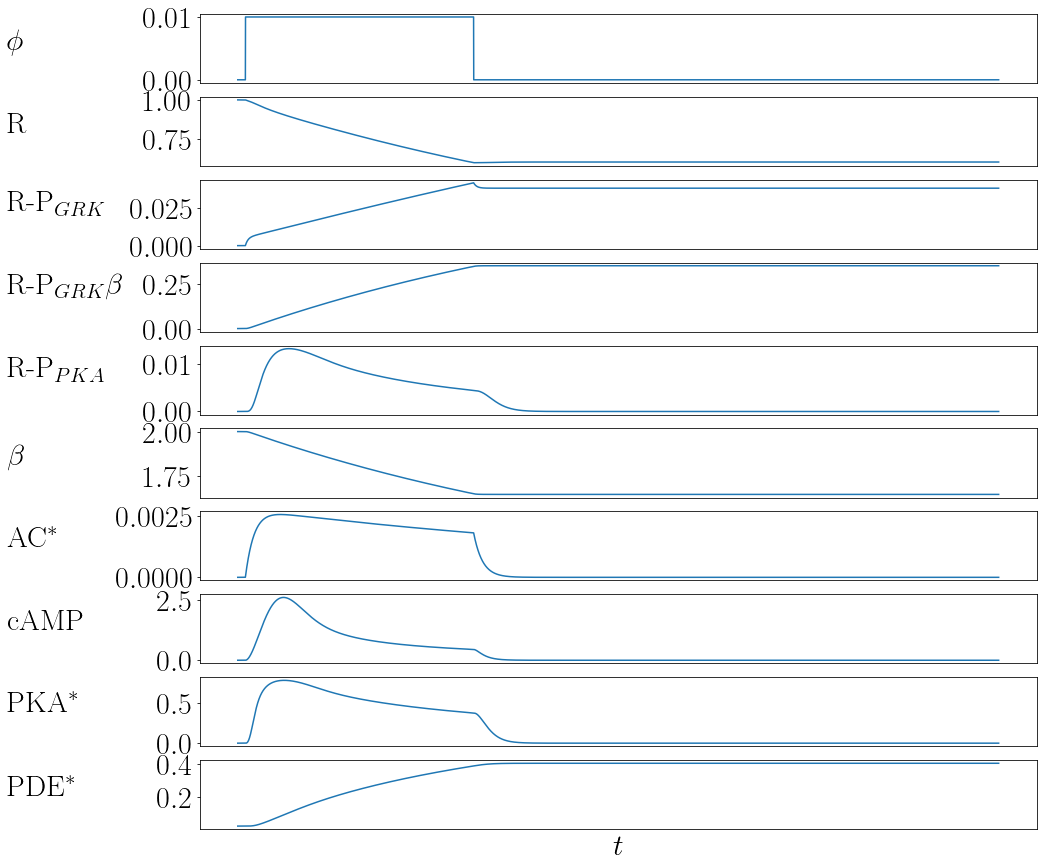

In [34]:
input_max=0.01
input_duration=300
run_experiment(input_type='pulse')
fig, ax = plt.subplots(10, 1, figsize=(15, 15))
plot_experiment_plots(['glut', 'R', 'R_Pgrk', 'R_Pgrkbeta', 'R_Ppka', 'beta', 'ACstar', 'cAMP', 'PKAstar', 'PDEstar'], ax,
                     add_xticks=False)

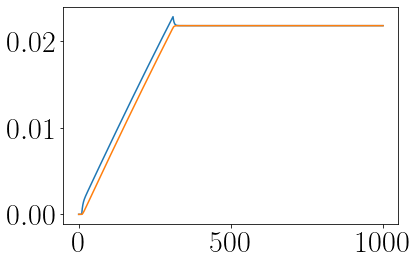

In [75]:
plt.plot(t, k5*beta*R_Pgrk)
plt.plot(t, k4*R_Pgrkbeta)

# Removing GRK Phosphorylation step

Here, I short circuited the phosphorylation by GRK step so we jump straight from R* to R*-PgrkBeta. This still relies on beta concentration, and I also multiplied in the terms relating to GRK concentration. To get comparable Gd1 desensitization levels to the original model, multiplied Gd1 rate by 5.

In [41]:
x_0 =             [1, 0,      0,   0,    0,    k13/k15, 2,    0]

def ode_equations(t, x, input_type='pulse'):
    '''
    ODE equations following the GPCR equations given earlier
    x[0] = [R-]: unphosphorylated receptor
    x[1] = [R-Pgrkbeta]: arrestin bound receptor
    x[2] = [AC*]: activated adenyl cyclase
    x[3] = [cAMP]: cAMP
    x[4] = [PKA*]: activated PKA
    x[5] = [PDE*]: activated PDE
    x[6] = [beta]: arrestin
    x[7] = [R-Ppka]: PKA phos receptor
    This returns x_dot, which is an array of the right hand sides of 
    each of the ODE equations in the same order as above
    
    input_type: given by ODE args, can be 'pulse' or 'step'
    '''
    R = x[0]
    R_Pgrkbeta = x[1]
    ACstar = x[2]
    cAMP = x[3]
    PKAstar = x[4]
    PDEstar = x[5]
    beta = x[6]
    R_Ppka = x[7]
#     R_Pgrkbeta = x[8]

    #query our glutamate function for what level glutamate is input
    glut = get_input_value(input_type, t)    
    
    Rstar = (R)*glut/(glut + kD)
    R_total = 1
#     R_Pgrkbeta = R_total - R - R_Pgrk - R_Ppka
    beta_total = 2 #paper has arrestin concentration at 2x that of R concentration
                   #since R-Pbeta is the only protein-protein interaction, this is the only
                   #concentration that needs to have a relative value
    AC_total = 1
    PKA_total = 1
    PDE_total = 1
    GRK = 1
    
    AC = AC_total - ACstar
    PKA = PKA_total - PKAstar
    PDE = PDE_total - PDEstar
    
    x_dot = np.zeros(8)
    
#     print(k4 * R_Pgrkbeta)
    
    x_dot[0] = -k1*GRK*glut/(glut + kD)*R*k5*beta*5 + k4*R_Pgrkbeta - k2*PKAstar*R + k3*R_Ppka
    x_dot[1] = k1*GRK*glut/(glut + kD)*R*k5*beta*5 - k4*R_Pgrkbeta
    x_dot[2] = k6*Rstar*AC - k7*ACstar
    x_dot[3] = k8*ACstar - k9*cAMP - k10*PDEstar*(cAMP/(kM + cAMP))
    x_dot[4] = k11*PKA*cAMP - k12*PKAstar
    x_dot[5] = k13 + k14*(PDE/(kM2+PDE))*PKAstar - k15*PDEstar
    x_dot[6] = k4*R_Pgrkbeta - k1*GRK*glut/(glut + kD)*k5*beta*5*R
    #These ODEs are not included in the paper, but seems like we need them.
    #Running these to make sure that formulas make sense and R_total is conserved
    x_dot[7] = k2*PKAstar*R - k3*R_Ppka
    
    return x_dot


def run_experiment(input_type='pulse', t_f=1000, max_step=0.1, remove_star_from_r=True):
    '''
    Run an experiment where glutamate is manually given by the specified input type
    
    remove_star_from_r: currently R* is given as a instantaneous function of R and [glut]
        If this is set to True, subtract the concentration of R* from R (so they add to 1)
        If it is False, R will be representative of R and R* (total receptor not deactivated)
    '''
    global t
    global t_input
    global glut
    global R
    global ACstar
    global cAMP
    global PKAstar
    global PDEstar
    global beta
    global R_Ppka
    global R_Pgrkbeta
    global Rstar
    
    sol = scipy.integrate.solve_ivp(ode_equations, [t_0, t_f], x_0, 
                                  args=[input_type], max_step=max_step)
    
    t = sol.t
    R = sol.y[0]
    R_Pgrkbeta = sol.y[1]
    ACstar = sol.y[2]
    cAMP = sol.y[3]
    PKAstar = sol.y[4]
    PDEstar = sol.y[5]
    beta = sol.y[6]
    R_Ppka = sol.y[7]
    
    #compute Rstar
    Rstar = R.copy()
    for i in range(len(t)):
        g = get_input_value(input_type, t[i])
        Rstar[i] = Rstar[i]*g/(g + kD)
        
    if(remove_star_from_r):
        for i in range(len(t)):
            g = get_input_value(input_type, t[i])
            R[i] = R[i]*kD/(g + kD)
    
    t_input, glut = get_input_plot(input_type)
    
    
    return sol


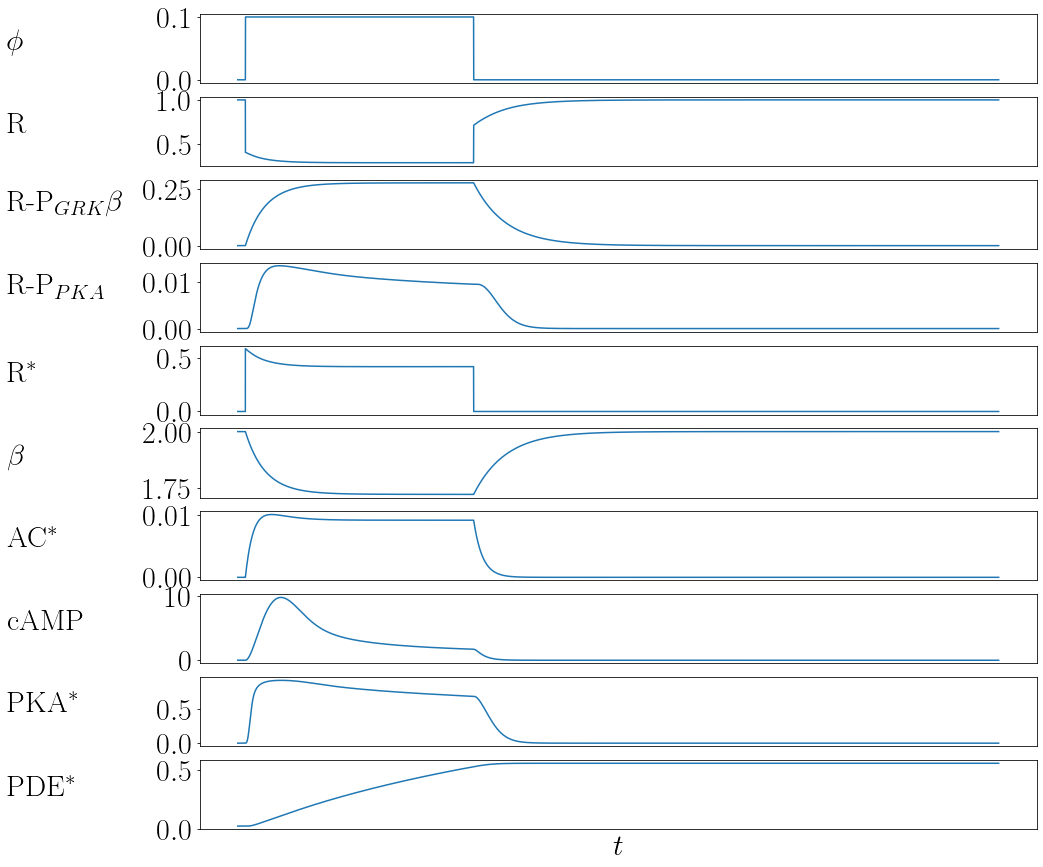

In [42]:
input_max=0.1
input_duration=300
run_experiment(input_type='pulse')
fig, ax = plt.subplots(10, 1, figsize=(15, 15))
plot_experiment_plots(['glut', 'R', 'R_Pgrkbeta', 'R_Ppka', 'Rstar', 'beta', 'ACstar', 'cAMP', 'PKAstar', 'PDEstar'], ax,
                     add_xticks=False)

# Only allowing G -> Gd2 (not G*)

If we only allow G -> Gd2, then we actually see a jump in Gd2 generation when glutamate input is turned off, as PKA is still high. The overall Gd2 generation is of course lower than before, but it is very clear that we can decouple the rates of Gd1 and Gd2 here.

(Also in this set of equations, got rid of the beta ODE since it can be derived from R_PgrkBeta)

In [10]:
x_0 =             [1, 0,      0,   0,    0,    k13/k15,    0]

def ode_equations(t, x, input_type='pulse'):
    '''
    ODE equations following the GPCR equations given earlier
    x[0] = [R-]: unphosphorylated receptor
    x[1] = [R-Pgrkbeta]: arrestin bound receptor
    x[2] = [AC*]: activated adenyl cyclase
    x[3] = [cAMP]: cAMP
    x[4] = [PKA*]: activated PKA
    x[5] = [PDE*]: activated PDE
    x[7] = [R-Ppka]: PKA phos receptor
    This returns x_dot, which is an array of the right hand sides of 
    each of the ODE equations in the same order as above
    
    input_type: given by ODE args, can be 'pulse' or 'step'
    '''
    R = x[0]
    R_Pgrkbeta = x[1]
    ACstar = x[2]
    cAMP = x[3]
    PKAstar = x[4]
    PDEstar = x[5]
#     beta = x[6]
    R_Ppka = x[6]
#     R_Pgrkbeta = x[8]

    #query our glutamate function for what level glutamate is input
    glut = get_input_value(input_type, t)    
    
    Rstar = (R)*glut/(glut + kD)
    R_total = 1
#     R_Pgrkbeta = R_total - R - R_Pgrk - R_Ppka
    beta_total = 2 #paper has arrestin concentration at 2x that of R concentration
                   #since R-Pbeta is the only protein-protein interaction, this is the only
                   #concentration that needs to have a relative value
    AC_total = 1
    PKA_total = 1
    PDE_total = 1
    GRK = 1
    
    beta = beta_total - R_Pgrkbeta
    AC = AC_total - ACstar
    PKA = PKA_total - PKAstar
    PDE = PDE_total - PDEstar
    
    x_dot = np.zeros(7)
    
#     print(k4 * R_Pgrkbeta)
    
    x_dot[0] = -k1*GRK*glut/(glut + kD)*R*k5*beta*5 + k4*R_Pgrkbeta - k2*PKAstar*R*kD/(glut + kD) + k3*R_Ppka
    x_dot[1] = k1*GRK*glut/(glut + kD)*R*k5*beta*5 - k4*R_Pgrkbeta
    x_dot[2] = k6*Rstar*AC - k7*ACstar
    x_dot[3] = k8*ACstar - k9*cAMP - k10*PDEstar*(cAMP/(kM + cAMP))
    x_dot[4] = k11*PKA*cAMP - k12*PKAstar
    x_dot[5] = k13 + k14*(PDE/(kM2+PDE))*PKAstar - k15*PDEstar
#     x_dot[6] = k4*R_Pgrkbeta - k1*GRK*glut/(glut + kD)*k5*beta*5*R
    #These ODEs are not included in the paper, but seems like we need them.
    #Running these to make sure that formulas make sense and R_total is conserved
    x_dot[6] = k2*PKAstar*R*kD/(glut + kD) - k3*R_Ppka
    
    return x_dot


def run_experiment(input_type='pulse', t_f=1000, max_step=0.1, remove_star_from_r=True):
    '''
    Run an experiment where glutamate is manually given by the specified input type
    
    remove_star_from_r: currently R* is given as a instantaneous function of R and [glut]
        If this is set to True, subtract the concentration of R* from R (so they add to 1)
        If it is False, R will be representative of R and R* (total receptor not deactivated)
    '''
    global t
    global t_input
    global glut
    global R
    global ACstar
    global cAMP
    global PKAstar
    global PDEstar
    global beta
    global R_Ppka
    global R_Pgrkbeta
    global Rstar
    
    sol = scipy.integrate.solve_ivp(ode_equations, [t_0, t_f], x_0, 
                                  args=[input_type], max_step=max_step)
    
    t = sol.t
    R = sol.y[0]
    R_Pgrkbeta = sol.y[1]
    ACstar = sol.y[2]
    cAMP = sol.y[3]
    PKAstar = sol.y[4]
    PDEstar = sol.y[5]
    R_Ppka = sol.y[6]
    
    #compute Rstar
    Rstar = R.copy()
    for i in range(len(t)):
        g = get_input_value(input_type, t[i])
        Rstar[i] = Rstar[i]*g/(g + kD)
        
    if(remove_star_from_r):
        for i in range(len(t)):
            g = get_input_value(input_type, t[i])
            R[i] = R[i]*kD/(g + kD)
            
    beta = 2 - R_Pgrkbeta
    
    t_input, glut = get_input_plot(input_type)
    
    
    return sol


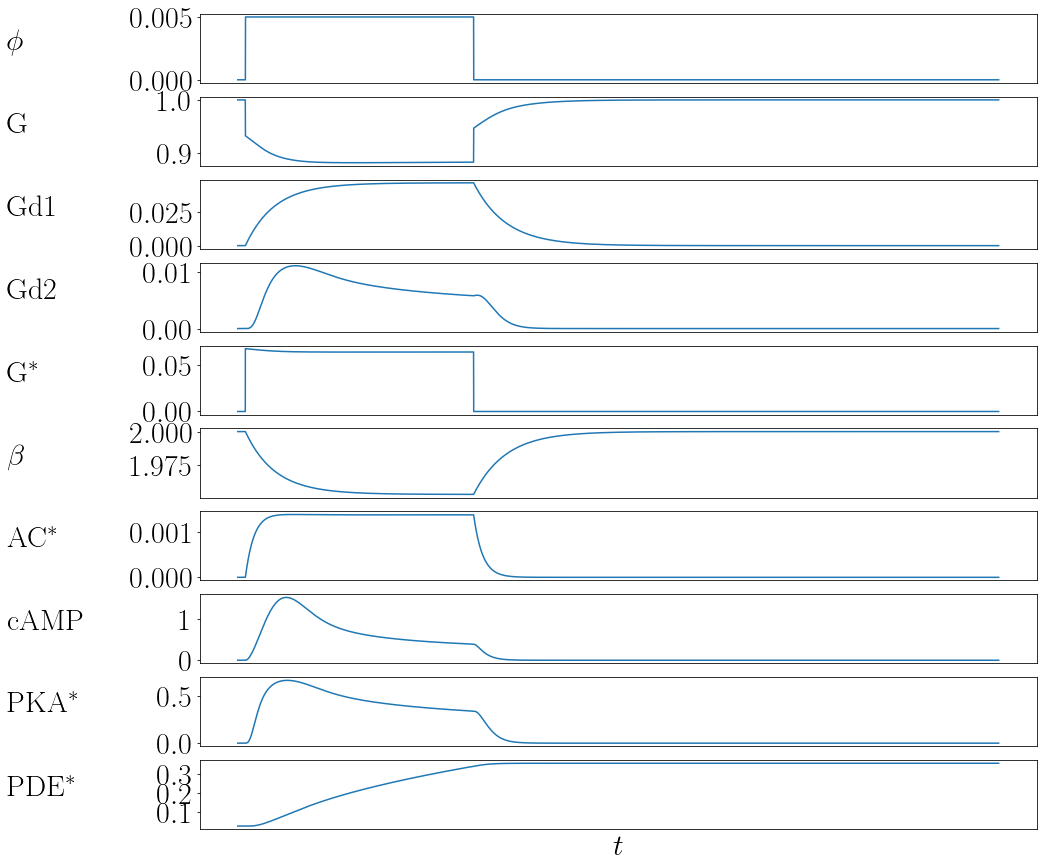

In [11]:
input_max=0.005
input_duration=300
run_experiment(input_type='pulse')
fig, ax = plt.subplots(10, 1, figsize=(15, 15))
plot_experiment_plots(['glut', 'R', 'R_Pgrkbeta', 'R_Ppka', 'Rstar', 'beta', 'ACstar', 'cAMP', 'PKAstar', 'PDEstar'], ax,
                     add_xticks=False)

# Simplification

Attempting to simplify all of the downstream pathway into a single PKA type thing. Since PKA is the protein that interacts with the receptor, we will try to model PKA* most closely with our singular downstream molecule. Effectively, PKA* development rate should depend on R*, and we will first attempt this with linear dependence on R*

PKA has negative feedback through the PDE -> cAMP degradation loop (and slower negative feedback through R* which is already baked into the model), so perhaps it is better to model rate as a saturating function.

In [12]:
x_0 =             [1, 0,      0,   0,    0,    k13/k15,    0]

def ode_equations(t, x, input_type='pulse'):
    '''
    ODE equations following the GPCR equations given earlier
    x[0] = [R-]: unphosphorylated receptor
    x[1] = [R-Pgrkbeta]: arrestin bound receptor
    x[2] = [R-Ppka]: PKA phos receptor
    x[3] = [PKA*]: activated PKA
    This returns x_dot, which is an array of the right hand sides of 
    each of the ODE equations in the same order as above
    
    input_type: given by ODE args, can be 'pulse' or 'step'
    '''
    R = x[0] #G
    R_Pgrkbeta = x[1] #Gd1
    R_Ppka = x[2] #Gd2
    PKAstar = x[3] #PKA

    #query our glutamate function for what level glutamate is input
    glut = get_input_value(input_type, t)    
    
    Rstar = (R)*glut/(glut + kD)
    R_total = 1
#     R_Pgrkbeta = R_total - R - R_Pgrk - R_Ppka
    beta_total = 2 #paper has arrestin concentration at 2x that of R concentration
                   #since R-Pbeta is the only protein-protein interaction, this is the only
                   #concentration that needs to have a relative value
    AC_total = 1
    PKA_total = 1
    PDE_total = 1
    GRK = 1
    
    beta = beta_total - R_Pgrkbeta
    AC = AC_total - ACstar
    PKA = PKA_total - PKAstar
    PDE = PDE_total - PDEstar
    
    x_dot = np.zeros(7)
    
#     print(k4 * R_Pgrkbeta)
    
    x_dot[0] = -k1*GRK*glut/(glut + kD)*R*k5*beta*5 + k4*R_Pgrkbeta - k2*PKAstar*R*2 + k3*R_Ppka
    x_dot[1] = k1*GRK*glut/(glut + kD)*R*k5*beta*5 - k4*R_Pgrkbeta
    x_dot[2] = k2*PKAstar*R*kD/(glut + kD)*2 - k3*R_Ppka
    x_dot[3] = 0.5*glut/(glut + kD)*R*PKA - k12*(PKAstar**2)*0.05 #dPKA*/dt
    
    return x_dot


def run_experiment(input_type='pulse', t_f=1000, max_step=0.1, remove_star_from_r=True):
    '''
    Run an experiment where glutamate is manually given by the specified input type
    
    remove_star_from_r: currently R* is given as a instantaneous function of R and [glut]
        If this is set to True, subtract the concentration of R* from R (so they add to 1)
        If it is False, R will be representative of R and R* (total receptor not deactivated)
    '''
    global t
    global t_input
    global glut
    global R
    global ACstar
    global cAMP
    global PKAstar
    global PDEstar
    global beta
    global R_Ppka
    global R_Pgrkbeta
    global Rstar
    
    sol = scipy.integrate.solve_ivp(ode_equations, [t_0, t_f], x_0, 
                                  args=[input_type], max_step=max_step)
    
    t = sol.t
    R = sol.y[0]
    R_Pgrkbeta = sol.y[1]
    R_Ppka = sol.y[2]
    PKAstar = sol.y[3]
    
    #compute Rstar
    Rstar = R.copy()
    for i in range(len(t)):
        g = get_input_value(input_type, t[i])
        Rstar[i] = Rstar[i]*g/(g + kD)
        
    if(remove_star_from_r):
        for i in range(len(t)):
            g = get_input_value(input_type, t[i])
            R[i] = R[i]*kD/(g + kD)
            
    beta = 2 - R_Pgrkbeta
    
    t_input, glut = get_input_plot(input_type)
    
    
    return sol


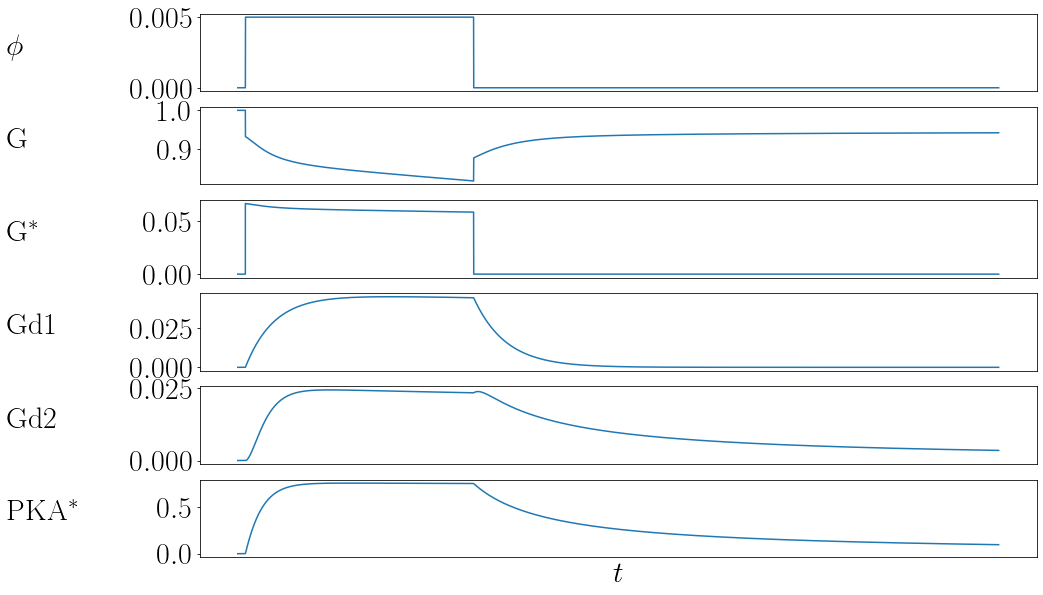

In [13]:
input_max=0.005
input_duration=300
run_experiment(input_type='pulse')
fig, ax = plt.subplots(6, 1, figsize=(15, 10))
plot_experiment_plots(['glut', 'R', 'Rstar', 'R_Pgrkbeta', 'R_Ppka', 'PKAstar'], ax,
                     add_xticks=False)